In [8]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('Rain_data_manipulated.csv', engine='python')
dataset.head()

,Unnamed: 0,RainToday,RainTomorrow,Pressure,Humidity,Temp,WindVelocity,Brightness
0,0,0.0,0,1007.40,46.5,19.35,66.0,34.148756
1,1,0.0,0,1009.20,34.5,20.75,57.0,34.148756
2,2,0.0,0,1008.15,34.0,22.10,68.5,34.148756
3,3,0.0,0,1015.20,30.5,22.30,34.0,34.148756
4,4,0.0,0,1008.40,57.5,23.75,54.5,57.186398


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np

In [10]:
Labels=np.array(dataset['RainTomorrow'])

In [11]:
Samples=np.array(dataset[['RainToday','Pressure','Humidity','Temp','WindVelocity','Brightness']])

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(copy=False)
Samples_normalized=scaler.fit(Samples)
Samples_normalized=scaler.transform(Samples)

In [17]:
Samples_normalized.shape

(142193, 6)

In [18]:
Samples_normalized=Samples_normalized.reshape(Samples.shape[0],1,Samples.shape[1])

In [19]:
import numpy as np
from keras.layers import LSTM
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
import json
import scipy
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [20]:
def weather_predictor(X_train,Y_train,hparam):
    
    model = Sequential()

    input_shape=(X_train.shape[1],X_train.shape[2])

    model.add(LSTM(units=30,return_sequences=True,input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(LSTM(units=30))
    model.add(Dropout(0.2))
    model.add(Dense(units=20))
    model.add(Dense(units=10))
    model.add(Dense(units=4))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy'])
    trainer=model.fit(X_train, Y_train, epochs=hparam.epoch,batch_size=hparam.batch,validation_split=hparam.eval_split)
    
    plt.plot(trainer.history['accuracy'])
    plt.plot(trainer.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.plot(trainer.history['loss'])
    plt.plot(trainer.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()

    return model

In [21]:
X_train,X_test,Y_train,Y_test=train_test_split(Samples_normalized,Labels,test_size=0.2,random_state=42)

In [22]:
class hparam_config():
      def __init__(self, epoch,batch,eval_split):
        self.epoch=epoch
        self.batch=batch
        self.eval_split=eval_split

param_list=hparam_config(epoch=10,batch=100,eval_split=0.2)

Train on 91003 samples, validate on 22751 samples
Epoch 1/10
91003/91003 [==============================] - 16s 180us/step - loss: 0.4866 - accuracy: 0.7945 - val_loss: 0.4705 - val_accuracy: 0.8094
Epoch 2/10
91003/91003 [==============================] - 10s 112us/step - loss: 0.4731 - accuracy: 0.8033 - val_loss: 0.4684 - val_accuracy: 0.8100
Epoch 3/10
91003/91003 [==============================] - 12s 128us/step - loss: 0.4695 - accuracy: 0.8062 - val_loss: 0.4664 - val_accuracy: 0.8105
Epoch 4/10
91003/91003 [==============================] - 13s 140us/step - loss: 0.4686 - accuracy: 0.8064 - val_loss: 0.4635 - val_accuracy: 0.8110
Epoch 5/10
91003/91003 [==============================] - 13s 143us/step - loss: 0.4685 - accuracy: 0.8057 - val_loss: 0.4634 - val_accuracy: 0.8105
Epoch 6/10
91003/91003 [==============================] - 14s 149us/step - loss: 0.4677 - accuracy: 0.8069 - val_loss: 0.4638 - val_accuracy: 0.8101
Epoch 7/10
91003/91003 [==============================] 

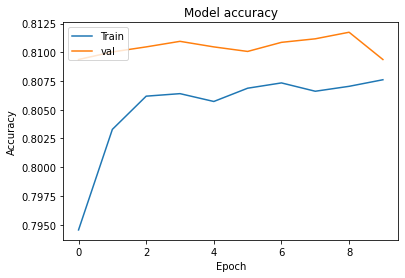

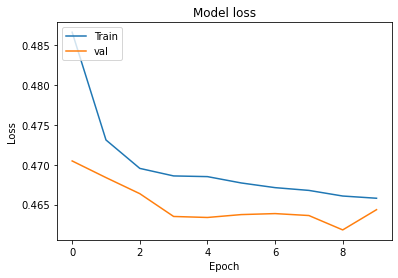

In [23]:
wraps=weather_predictor(X_train,Y_train,param_list)

In [27]:
Y_pred=wraps.predict_proba(X_test)

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

0.6973190341388904


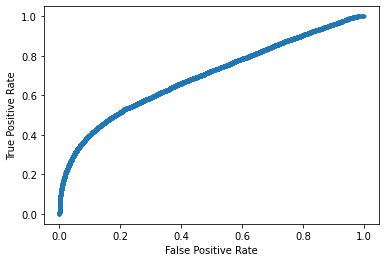

In [30]:
lr_auc = roc_auc_score(Y_test,Y_pred)
print(lr_auc)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Wraps')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [31]:
from sklearn.metrics import accuracy_score
Y_pred=Y_pred>0.5
accuracy_score(Y_test,Y_pred)

0.8067794226238616

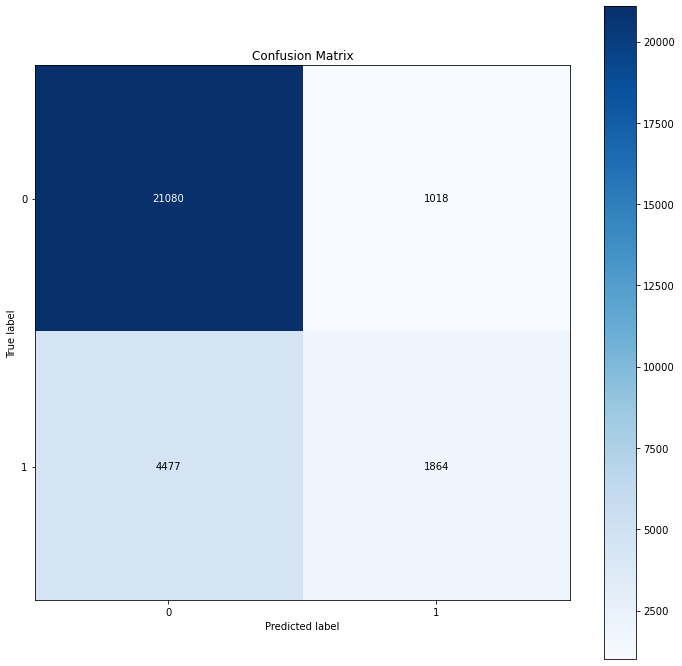

In [32]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    Y_test, 
    Y_pred,
    figsize=(12,12))

In [33]:
from keras.models import save_model
wraps.save('Wraps_LSTM_predictor.h5')  #*****************Run this cell only for improved models.